***
In this notebook, we will walk through creating pcraster maps related to catchment delineations for a SPHY model input.
***

# 00. Load Packages

In [1]:
import os
import pcraster as pcr
import pcr_tool

import cartopy

# 01. Basic Setup for a Bhutan watershed (Punatsangchhu, Wangchhu, Amochhu, and Jaldakah)

In [2]:
epsg_model = 5266 # Bhutan National Grid: a transverse Mercator projection
epsg_lonlat = 4326 # the common lat-lon coordinate reference system

path_data = os.path.join('..', 'data')
path_output = os.path.join('..', 'input') # the "input" folder will be directly used as an input path for the SPHY model run
os.makedirs(path_output, exist_ok = True)

# plotting options
flag_plot_aguila = True
flag_plot_cartopy = True

# Bhutan Administrative Boundaries (Level 1) to be added in a plot
path_shape = os.path.join(path_data, 'SHAPE', 'btn_admbnda_adm1_bnlc_20201026.shp')
shape_geometry = cartopy.io.shapereader.Reader(path_shape).geometries()
shape_feature = cartopy.feature.ShapelyFeature(shape_geometry, crs = cartopy.crs.PlateCarree(), facecolor = 'none', linewidth = 0.25)

# 02. Load Clonemap and DEM

First, we need to declare the class that we will be using throughout this notebook, with an EPSG to define a clonemap.

In [3]:
print(f'- Input EPSG:\n{epsg_model}')
map_clone = pcr_tool.clonemap(epsg = epsg_model)

- Input EPSG:
5266


Let's load the clonemap and DEM that we generated in the previous notebook.

In [4]:
# load clonemap
path_clonemap = os.path.join(path_output, 'clone.map')
print(f'- Input PCRaster Path for Clonemap:\n{path_clonemap}')
map_clone.load_clonemap(path = path_clonemap)

# load DEM
path_dem = os.path.join(path_output, 'dem.map')
print(f'- Input PCRaster Path for DEM:\n{path_dem}')
map_dem = map_clone.read_pcraster(path = path_dem)
map_clone.set_dem(map_dem)

print('- Outputs:')
print(map_dem)

# plots
if flag_plot_aguila:
    pcr.aguila(map_clone.clonemap)
    pcr.aguila(map_dem)

- Input PCRaster Path for Clonemap:
../input/clone.map
- Input PCRaster Path for DEM:
../input/dem.map
- Outputs:


# 03. Calculate Topographic Slope and Flow Direction

We're first going to calculate the topographic slopes from DEM.

- Outputs:
write_pcraster: written to ../input/slope.map.


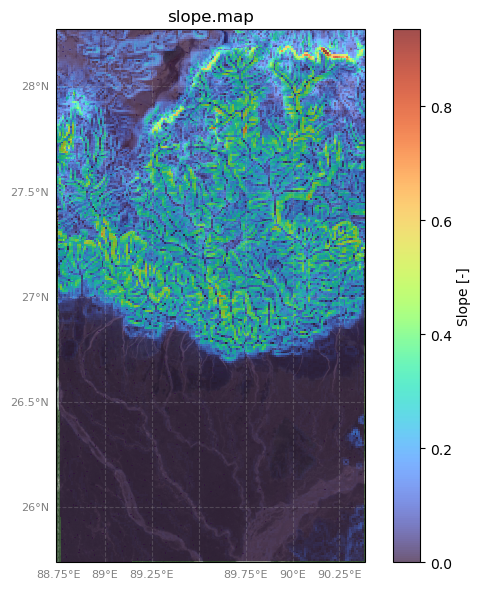

In [5]:
# calculate_slope: a wrapper for pcraster.slope (see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/pcraster_manual/sphinx/op_slope.html)
# one can directly use the pcraster function, pcraster.slope, to refine the function parameters
map_slope = map_clone.calculate_slope()

print('- Outputs:')
print(map_slope)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'slope.map'), # path to write in the pcraster format
    field = map_slope, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_slope)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_slope, # pcraster.Field to plot
        shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, OpenStreetMap)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'slope.map', # matplotlib figure title
        clabel = 'Slope [-]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

From DEM, we can also derive the flow directions based on the following definition - numbers assigned to the flow directions: <br>
    7 8 9 <br>
    4 5 6 <br>
    1 2 3 <br>
Note: 5 represents a pit.

- Outputs:
write_pcraster: written to ../input/ldd.map.


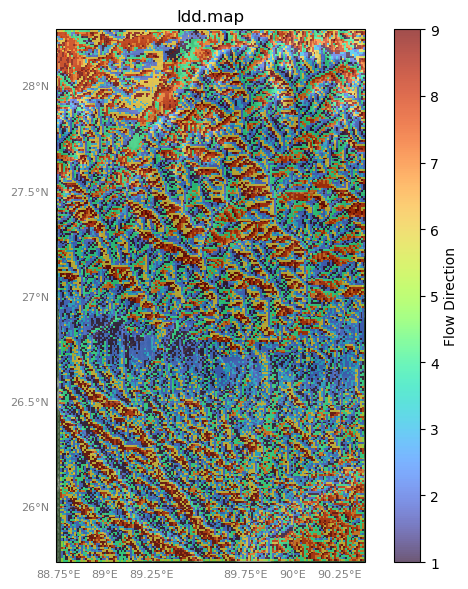

In [6]:
# calculate_flowdir: a wrapper for pcraster.lddcreate (see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/pcraster_manual/sphinx/op_lddcreate.html)
# one can directly use the pcraster function, pcraster.lddcreate, to refine the function parameters
map_flowdir = map_clone.calculate_flowdir()

print('- Outputs:')
print(map_flowdir)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'ldd.map'), # path to write in the pcraster format
    field = map_flowdir, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_flowdir) # need to zoom on the map to see the flow directions
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_flowdir, # pcraster.Field to plot
        shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'ldd.map', # matplotlib figure title
        clabel = 'Flow Direction', # matplotlib contour label
        savefig = None, # path to save the figure
        )

While the following two cells are not required for the SPHY model runs, we can check stream order and flow accumulation to make sure that the stream channels are generated correctly as expected.<br>

If the generated stream channels are not aligned with other sources of information, you may want to apply conditioning for DEM and repeat the same procedure until the generated stream channels meet your expectations.

- Outputs:
write_pcraster: written to ../input/streamorder.map.
write_pcraster: written to ../input/streamorder_ge3.map.


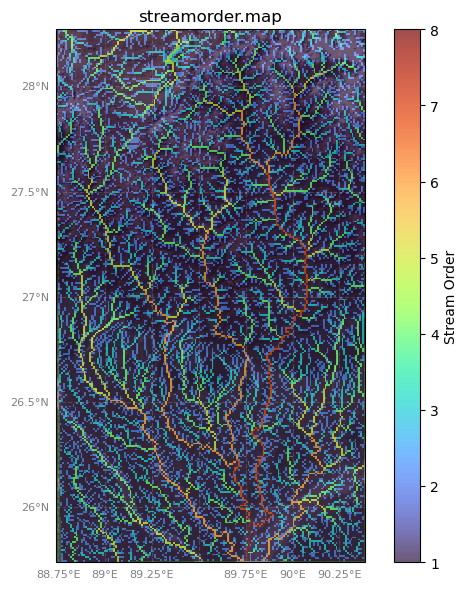

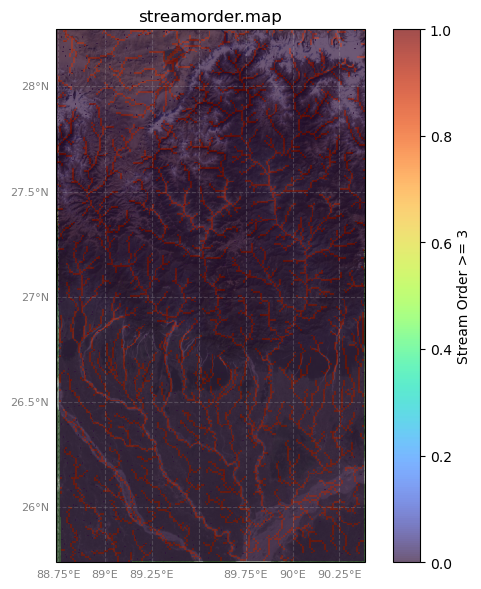

In [7]:
# create_streamorder: a wrapper for pcraster.streamorder (see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/pcraster_manual/sphinx/op_streamorder.html)
# one can directly use the pcraster function, pcraster.streamorder, to refine the function parameters
threshold_streamorder = 3 # assume that the stream order of three or more would imply the streamflow channels

map_streamorder = map_clone.create_streamorder()
map_streamorder_threshold = pcr.ifthen(map_streamorder >= threshold_streamorder, pcr.boolean(1)) # replace the stream order of three or more with True, otherwise return the missing value

print('- Outputs:')
print(map_streamorder)
print(map_streamorder_threshold)

# export into pcraster files
map_clone.write_pcraster(
    path = os.path.join(path_output, 'streamorder.map'), # path to write in the pcraster format
    field = map_streamorder, # pcraster.Field to write
    )
map_clone.write_pcraster(
    path = os.path.join(path_output, f'streamorder_ge{threshold_streamorder}.map'), # path to write in the pcraster format
    field = map_streamorder_threshold, # pcraster.Field to write
    )

# plots
if flag_plot_aguila:
    pcr.aguila(map_streamorder)
    pcr.aguila(map_streamorder_threshold)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_streamorder, # pcraster.Field to plot
        shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'streamorder.map', # matplotlib figure title
        clabel = 'Stream Order', # matplotlib contour label
        savefig = None, # path to save the figure
        )
    map_clone.plot_cartopy(
        field = map_streamorder_threshold, # pcraster.Field to plot
        shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'streamorder.map', # matplotlib figure title
        clabel = f'Stream Order >= {threshold_streamorder}', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Outputs:
write_pcraster: written to ../input/accuflux.map.
write_pcraster: written to ../input/accuflux_ge25.map.


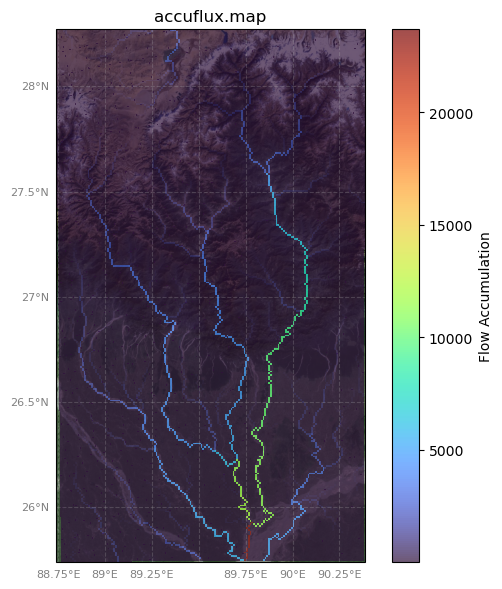

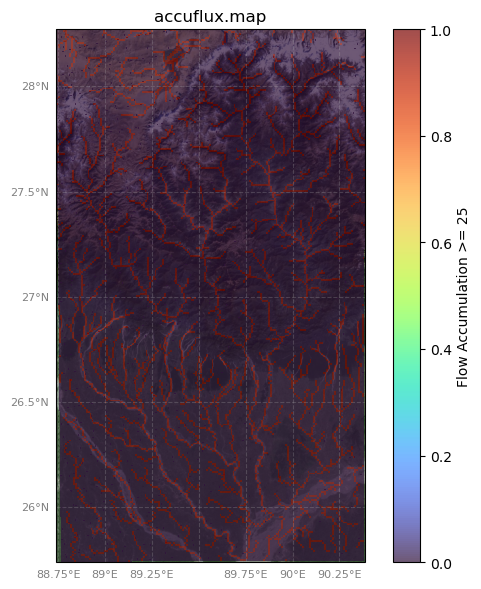

In [8]:
# create_accuflux: a wrapper for pcraster.accuflux (see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/pcraster_manual/sphinx/op_accuflux.html)
# one can directly use the pcraster function, pcraster.accuflux, to refine the function parameters
threshold_accuflux = 25 # assume that the flow accumulation of 25 or more would imply the streamflow channels

map_accuflux = map_clone.create_accuflux()
map_accuflux_threshold = pcr.ifthen(map_accuflux >= threshold_accuflux, pcr.boolean(1)) # replace the flow accumulation of 25 or more with True, otherwise return the missing value

print('- Outputs:')
print(map_accuflux)
print(map_accuflux_threshold)

# export into pcraster files
map_clone.write_pcraster(
    path = os.path.join(path_output, 'accuflux.map'), # path to write in the pcraster format
    field = map_accuflux, # pcraster.Field to write
    )
map_clone.write_pcraster(
    path = os.path.join(path_output, f'accuflux_ge{threshold_accuflux}.map'), # path to write in the pcraster format
    field = map_accuflux_threshold, # pcraster.Field to write
    )

# plots
if flag_plot_aguila:
    pcr.aguila(map_accuflux)
    pcr.aguila(map_accuflux_threshold)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_accuflux, # pcraster.Field to plot
        shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'accuflux.map', # matplotlib figure title
        clabel = 'Flow Accumulation', # matplotlib contour label
        savefig = None, # path to save the figure
        )
    map_clone.plot_cartopy(
        field = map_accuflux_threshold, # pcraster.Field to plot
        shapes = [], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'accuflux.map', # matplotlib figure title
        clabel = f'Flow Accumulation >= {threshold_accuflux}', # matplotlib contour label
        savefig = None, # path to save the figure
        )

# 04. Select Points of Interest (e.g., catchment outlets and gauge stations)

Let's first assign potential catchment outlets to delineate catchments.

- Input EPSG for Points of Interest:
4326
- Outputs:
[[ 237560.25869423 3053456.71084297]
 [ 235585.69429293 3053458.8818438 ]
 [ 241501.07934894 3041485.61486647]
 [ 239524.58499355 3041487.14329905]
 [ 255561.46660119 2980429.33011378]
 [ 253575.22833099 2980428.60776808]
 [ 229561.28366977 2867433.55042025]
 [ 227550.67173688 2863448.49132224]
 [ 225527.75684236 2853481.31691362]
 [ 221707.71645181 2849389.87097037]]
write_pcraster: written to ../input/outlet.map.


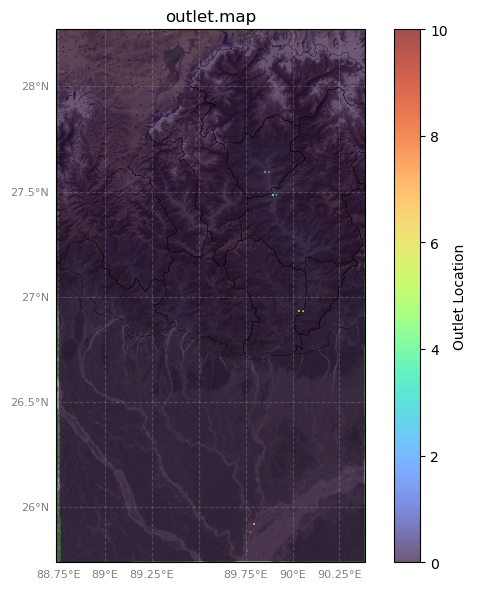

In [9]:
# assign a list of potential catchment outlets
list_outlet = [
    [27.594, 89.874], # 1
    [27.594, 89.854], # 2
    [27.486, 89.914], # 3
    [27.486, 89.894], # 4
    [26.935, 90.056], # 5
    [26.935, 90.036], # 6
    [25.915, 89.796], # 7
    [25.879, 89.776], # 8
    [25.789, 89.756], # 9
    [25.752, 89.718], # 10
    ]

print(f'- Input EPSG for Points of Interest:\n{epsg_lonlat}')
map_outlet, list_outlet_epsg_model = map_clone.create_outlet(
    outlets = list_outlet, # a list of potential catchment outlets
    epsg = epsg_lonlat, # input EPSG
    )

print('- Outputs:')
print(map_outlet)
print(list_outlet_epsg_model)

# export into pcraster files
map_clone.write_pcraster(
    path = os.path.join(path_output, 'outlet.map'), # path to write in the pcraster format
    field = map_outlet, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_outlet)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_outlet, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'outlet.map', # matplotlib figure title
        clabel = 'Outlet Location', # matplotlib contour label
        savefig = None, # path to save the figure
        )

Then, we can delineate catchmants, using the flow directions and potential catchment outlets.

- Outputs:
write_pcraster: written to ../input/catchment.map.


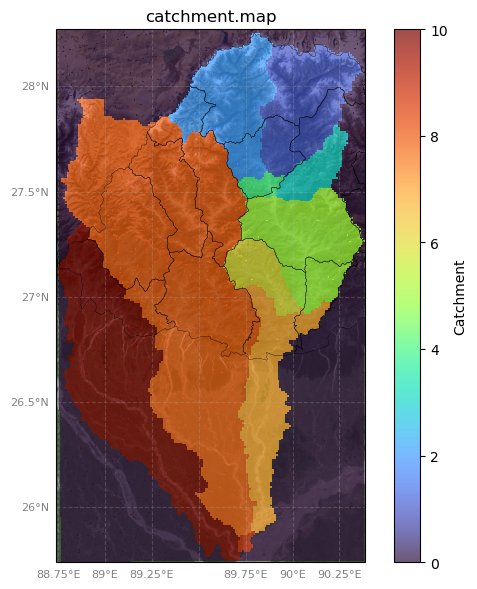

In [10]:
# create_subcatchment: a wrapper for pcraster.subcatchment (see https://pcraster.geo.uu.nl/pcraster/4.4.1/documentation/pcraster_manual/sphinx/op_subcatchment.html)
# one can directly use the pcraster function, pcraster.subcatchment, to refine the function parameters
map_catchment = map_clone.create_subcatchment()

print('- Outputs:')
print(map_catchment)

# export into pcraster files
map_clone.write_pcraster(
    path = os.path.join(path_output, 'catchment.map'), # path to write in the pcraster format
    field = map_catchment, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_catchment)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_catchment, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'catchment.map', # matplotlib figure title
        clabel = 'Catchment', # matplotlib contour label
        savefig = None, # path to save the figure
        )

**NOTE**: If the generated catchments are not aligned with other sources of information, it would be likely that the flow directions and outlet locations cannot properly identify catchments. You may want to adjust the outlet locations or apply conditioning for DEM to derive the flow directions correctly, and repeat the same procedure until the generated catchments meet your expectations. The native PCRatser tools provide several DEM conditioning options.

Once we have reasonable catchment delinations, we should include addtional locations, such as streamflow gauges.

- Input EPSG for Points of Interest:
4326
- Outputs:
[[ 237560.25869423 3053456.71084297]
 [ 235585.69429293 3053458.8818438 ]
 [ 241501.07934894 3041485.61486647]
 [ 239524.58499355 3041487.14329905]
 [ 255561.46660119 2980429.33011378]
 [ 253575.22833099 2980428.60776808]
 [ 229561.28366977 2867433.55042025]
 [ 227550.67173688 2863448.49132224]
 [ 225527.75684236 2853481.31691362]
 [ 221707.71645181 2849389.87097037]
 [ 240665.54798526 3034372.16533966]
 [ 237505.30067363 3028546.36086042]
 [ 239590.09949752 3025463.92522747]
 [ 242052.26432252 2991699.31969612]
 [ 203504.65320765 2999960.88191679]
 [ 202577.6644649  2998701.1504747 ]
 [ 208704.71112207 2995188.91543258]
 [ 209854.10581051 2991694.74405422]
 [ 202458.8861283  3014314.74485583]
 [ 192647.01101952 3034302.84975543]
 [ 216388.5901274  3037539.44965255]
 [ 179766.40486611 3029936.90492835]
 [ 180254.75224086 3028825.95269886]]
write_pcraster: written to ../input/outlet.map.


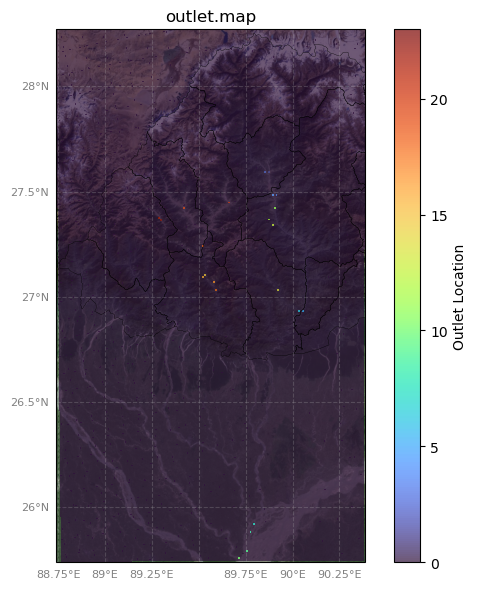

In [11]:
list_outlet = list_outlet + [
    [27.4218, 89.9056], # 11: Punatsangchhu-I Hydropower Plant
    [27.3692, 89.8737], # 12: Basochhu Hydropower Plant Upper
    [27.3414, 89.8948], # 13: Basochhu Hydropower Plant Lower
    [27.0367, 89.9199], # 14: Dagachhu Hydropower Plant
    [27.1105, 89.5311], # 15: Chhukha Hydropower Plant
    [27.0991, 89.5218], # 16
    [27.0676, 89.5837], # 17
    [27.0361, 89.5954], # 18: Tala Hydropower Plant
    [27.24, 89.52], # 19: Tamchu on Wang Chhu Station, [27.24, 89.53]
    [27.42, 89.42], # 20: Paro on Paro Chuu Station, [27.43, 89.43]
    [27.45, 89.66], # 21: Lungtenphung on Thimp,
 #   [27.11, 89.53], # Chimakoti Dam on Wan = [27.1105, 89.5311], # 15: Chhukha Hydropower Plant
    [27.38, 89.29], # 22: Haa on Damchhu, [27.38, 89.29]
    [27.37, 89.295], # 23: Haa on Haa Chhu, [27.37, 89.29]
    ]

print(f'- Input EPSG for Points of Interest:\n{epsg_lonlat}')
map_outlet, list_outlet_epsg_model = map_clone.create_outlet(
    outlets = list_outlet, # a list of potential catchment outlets
    epsg = epsg_lonlat, # input EPSG
    )

print('- Outputs:')
print(map_outlet)
print(list_outlet_epsg_model)

# export into pcraster files
map_clone.write_pcraster(
    path = os.path.join(path_output, 'outlet.map'), # path to write in the pcraster format
    field = map_outlet, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_outlet)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_outlet, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'outlet.map', # matplotlib figure title
        clabel = 'Outlet Location', # matplotlib contour label
        savefig = None, # path to save the figure
        )

**OPTIONAL**: If the catchment outlets are represented by pits (e.g., along the domain boundary), we can use the pcraster function, pcraster.pit, to find pits and delineate catchments based on the pits.

- Outputs:


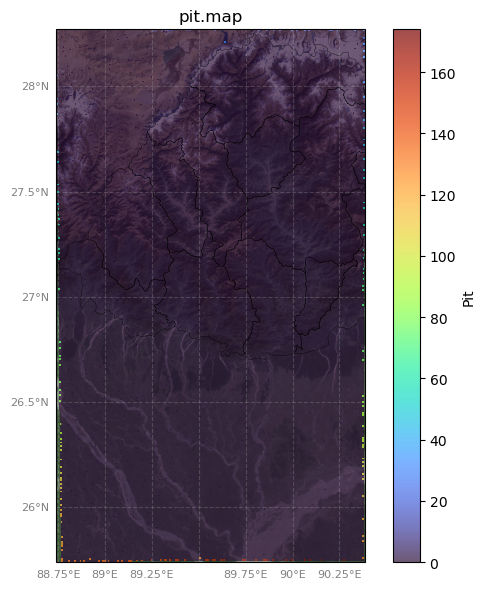

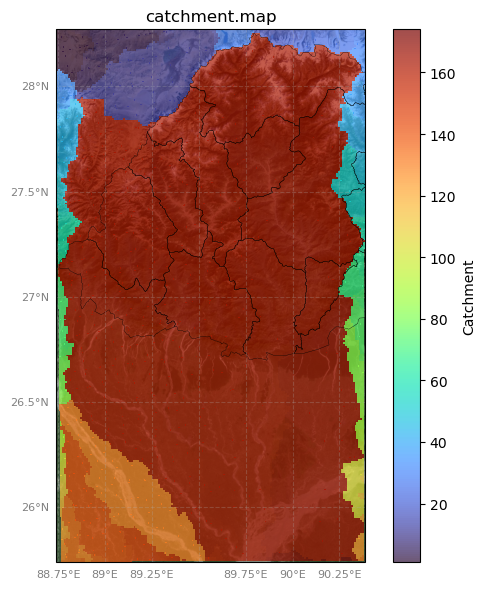

In [12]:
map_outlet_pit = pcr.pit(map_flowdir) # find pits on the domain
map_catchment_pit = pcr.catchment(map_flowdir, map_outlet_pit) # delineate catchments based on the pits

print('- Outputs:')
print(map_outlet_pit)
print(map_catchment_pit)

# plots
if flag_plot_aguila:
    pcr.aguila(map_outlet_pit)
    pcr.aguila(map_catchment_pit)
if flag_plot_cartopy:    
    map_clone.plot_cartopy(
        field = map_outlet_pit, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'pit.map', # matplotlib figure title
        clabel = 'Pit', # matplotlib contour label
        savefig = None, # path to save the figure
        )
    map_clone.plot_cartopy(
        field = map_catchment_pit, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'catchment.map', # matplotlib figure title
        clabel = 'Catchment', # matplotlib contour label
        savefig = None, # path to save the figure
        )